Ordinal regression
--
Ordinal regression aims to fit a model to some data $(X, Y)$, where $Y$ is an ordinal variable. To do so, we use a `VPG` model with a specific likelihood (`gpflow.likelihoods.Ordinal`).

In [1]:
import gpflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

np.random.seed(123)  # for reproducibility

Text(0, 0.5, 'observed data value')

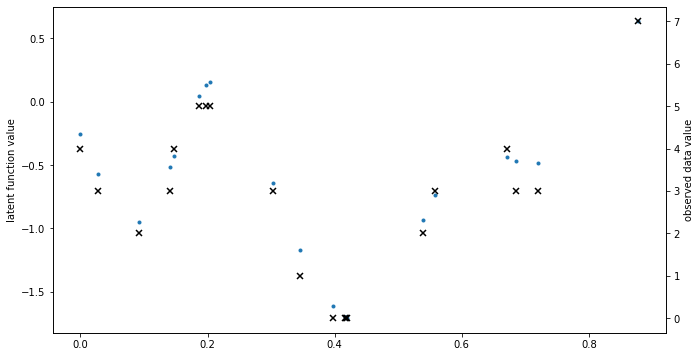

In [2]:
# make a one-dimensional ordinal regression problem

# This function generates a set of inputs X,
# quantitative output f (latent) and ordinal values Y


def generate_data(num_data):
    # First generate random inputs
    X = np.random.rand(num_data, 1)

    # Now generate values of a latent GP
    kern = gpflow.kernels.SquaredExponential(lengthscales=0.1)
    K = kern(X)
    f = np.random.multivariate_normal(mean=np.zeros(num_data), cov=K).reshape(-1, 1)

    # Finally convert f values into ordinal values Y
    Y = np.round((f + f.min()) * 3)
    Y = Y - Y.min()
    Y = np.asarray(Y, np.float64)

    return X, f, Y


np.random.seed(1)
num_data = 20
X, f, Y = generate_data(num_data)

plt.figure(figsize=(11, 6))
plt.plot(X, f, ".")
plt.ylabel("latent function value")

plt.twinx()
plt.plot(X, Y, "kx", mew=1.5)
plt.ylabel("observed data value")

In [3]:
# construct ordinal likelihood - bin_edges is the same as unique(Y) but centered
bin_edges = np.array(np.arange(np.unique(Y).size + 1), dtype=float)
bin_edges = bin_edges - bin_edges.mean()
likelihood = gpflow.likelihoods.Ordinal(bin_edges)

# build a model with this likelihood
m = gpflow.models.VGP(data=(X, Y), kernel=gpflow.kernels.Matern32(), likelihood=likelihood)

# fit the model
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

      fun: 25.487471968563476
 hess_inv: <233x233 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.26236452e-01, -8.42171287e-03, -9.92714027e-03, -6.68913863e-02,
       -2.49079202e-02, -3.88847203e-02, -4.35378689e-02, -6.55268236e-02,
       -2.94189677e-02, -6.95103659e-02, -5.22843527e-04, -1.27492005e-02,
        2.11607195e-02,  5.11052852e-03,  1.45597186e-02,  6.93373613e-03,
       -2.49450988e-02, -9.35484066e-03, -2.19389062e-02, -2.07845067e-04,
       -1.23515809e-02, -2.20744260e-02, -1.66761668e-03,  2.76984806e-04,
       -4.08027759e-04, -5.73223183e-09,  2.48722305e-06, -1.87076568e-09,
       -7.61076788e-06,  1.95549081e-11, -6.40799483e-03,  1.96574567e-08,
        2.45316896e-06, -2.35300586e-07, -2.04579221e-05,  1.53874469e-04,
       -3.34516557e-03,  2.68185035e-04,  5.34598758e-05,  1.70428444e-04,
       -1.96304163e-04, -1.50880360e-04,  3.34725448e-04, -2.61933718e-02,
        7.39315873e-03, -3.48325914e-09,  1.01723924e-06, -2.11522258e-10,

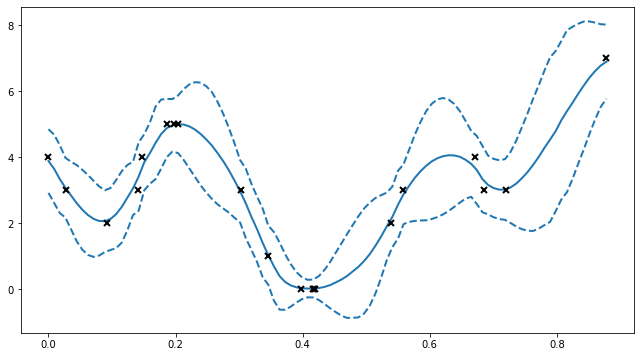

In [4]:
# here we'll plot the expected value of Y +- 2 std deviations, as if the distribution were Gaussian
plt.figure(figsize=(11, 6))
X_data, Y_data = (m.data[0].numpy(), m.data[1].numpy())
Xtest = np.linspace(X_data.min(), X_data.max(), 100).reshape(-1, 1)
mu, var = m.predict_y(Xtest)
(line,) = plt.plot(Xtest, mu, lw=2)
col = line.get_color()
plt.plot(Xtest, mu + 2 * np.sqrt(var), "--", lw=2, color=col)
plt.plot(Xtest, mu - 2 * np.sqrt(var), "--", lw=2, color=col)
plt.plot(X_data, Y_data, "kx", mew=2)

In [5]:
## to see the predictive density, try predicting every possible discrete value for Y.
def pred_log_density(m):
    Xtest = np.linspace(X_data.min(), X_data.max(), 100).reshape(-1, 1)
    ys = np.arange(Y_data.max() + 1)
    densities = []
    for y in ys:
        Ytest = np.full_like(Xtest, y)
        # Predict the log density
        densities.append(m.predict_log_density((Xtest, Ytest)))
    return np.vstack(densities)

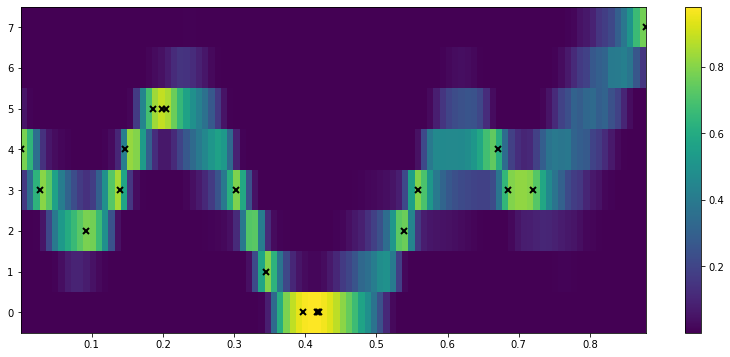

In [6]:
fig = plt.figure(figsize=(14, 6))
plt.imshow(
    np.exp(pred_log_density(m)),
    interpolation="nearest",
    extent=[X_data.min(), X_data.max(), -0.5, Y_data.max() + 0.5],
    origin="lower",
    aspect="auto",
    cmap=plt.cm.viridis,
)
plt.colorbar()
plt.plot(X, Y, "kx", mew=2, scalex=False, scaley=False)

<BarContainer object of 8 artists>

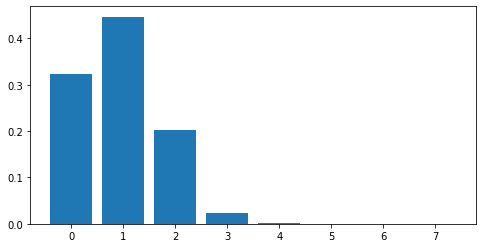

In [7]:
# Predictive density for a single input x=0.5
x_new = 0.5
Y_new = np.arange(np.max(Y_data + 1)).reshape([-1, 1])
X_new = np.full_like(Y_new, x_new)
# for predict_log_density x and y need to have the same number of rows
dens_new = np.exp(m.predict_log_density((X_new, Y_new)))
fig = plt.figure(figsize=(8, 4))
plt.bar(x=Y_new.flatten(), height=dens_new.flatten())